<a href="https://colab.research.google.com/github/carlaprv/sin5007-reconhecimento-de-padroes/blob/master/07%20-%20Naive%20Bayes%20%2B%20SVM%20v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/carlaprv/sin5007-reconhecimento-de-padroes cloned-repo
%cd cloned-repo
!ls

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo
'02 - Normalizacao_dataset_v01.ipynb'
'02 - Normalizacao_dataset_v02.ipynb'
'02 - Normalizacao_dataset_v03-portugues.ipynb'
'03 - PCA_v01.ipynb'
'03 - PCA_v02-portugues.ipynb'
'04 - 01 Features Selection - Chi Squared v01.ipynb'
'04 - 01 Features Selection - Chi Squared v02.ipynb'
'04 - 02 Features Selection - Recursive Feature Elimination.ipynb'
'04 - 02 Features Selection - Recursive Feature Elimination v02.ipynb'
'04 - 03 Features Selection - Feature Importance.ipynb'
'04 - 03 Features Selection - Feature Importance v02.ipynb'
'04 - 04 Features Selection - Correlation Matrix.ipynb'
'04 - 05 Features Selection - Select from Model.ipynb'
'04 - 06 Features Selection Comparison.ipynb'
'05 - Function k-fold cross validation-(biblioteca sklearn).ipynb'
'05 - Function k-fold cross validation.ipynb'
'06 - k-fold cross validation + naive bayes v01.ipynb'
'06 - k-fold cross validation + na

# Naive Bayes + SVM
-------------------------------------------------------------------------------------------------------------

# Bibliotecas Necessárias

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns # visualize
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.weightstats import DescrStatsW
import warnings

warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Funções Auxiliares

describe_dataset() : realiza o cálculo das proporções de classes do dataset original

In [0]:
def describe_dataset(X, y, k):
    # get dataset rows: instances , columns: features
    rows, columns = X.shape
    # get proportion from target
    (unique, counts) = np.unique(y, return_counts=True) 
    # calculate proportion
    prop_neg = int(counts[0]/rows*100)
    prop_pos = int(counts[1]/rows*100)

    print("k = {}, Dataset: {} positivas, {} negativas ({}% x {}%)".format(k, counts[1], counts[0], prop_pos, prop_neg))
    print("")

get_classes_from_index() : realiza o cálculo das proporções de classes dos folds criados

In [0]:
def get_classes_from_index(y, skf):
    _, y_idx, y_inv = np.unique(y, return_index=True, return_inverse=True)
    y_counts = np.bincount(y_inv)
    _, class_perm = np.unique(y_idx, return_inverse=True)
    y_encoded = class_perm[y_inv]
    y_order = np.sort(y_encoded)
    n_classes = len(y_idx)
    allocation = np.asarray(
            [np.bincount(y_order[i::skf.n_splits], minlength=n_classes)
             for i in range(skf.n_splits)])

    for idx, f in enumerate(allocation):
        count_neg = int(f[0])
        count_pos = int(f[1])
        total = count_neg+count_pos
        prop_temp_neg = int(count_neg/total*100)
        prop_temp_pos = int(count_pos/total*100)
        print("Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {}% x {}%".format(idx, count_pos, count_neg, total, prop_temp_pos, prop_temp_neg))
    print("")

get_ic(): realiza o cálculo do indice de confiança

In [0]:
def get_ic(data, alpha):
    
    mean_c = []
    for result in lista_result:
        
        c = result[0]
        result_c = result[1]
        
        # Calcula a média das medidas do parametro c
        precision_mean = result_c['precision'].mean()
        recall_mean = result_c['recall'].mean()
        f1_score_mean = result_c['f1-score'].mean()
        support_mean = result_c['support'].mean()
        accuracy_mean = result_c['accuracy'].mean()

        # Calcula as ic das medidas
        precision_ic = sms.DescrStatsW(result_c['precision']).tconfint_mean(alpha)
        recall_ic = sms.DescrStatsW(result_c['recall']).tconfint_mean(alpha)
        f1_score_ic = sms.DescrStatsW(result_c['f1-score']).tconfint_mean(alpha)
        support_ic = sms.DescrStatsW(result_c['support']).tconfint_mean(alpha)
        accuracy_ic = sms.DescrStatsW(result_c['accuracy']).tconfint_mean(alpha)

        ic = {'recall_ic' : recall_ic, 'support_ic' : support_ic, 'accuracy_ic': accuracy_ic }
        ic = pd.DataFrame(ic, index=['inf','sup'])

        # Armazena a média das medidas do parametro c
        mean_c.append([c, precision_mean, recall_mean, f1_score_mean, support_mean, accuracy_mean])
    
    name_columns = ['c', 'precision_mean', 'recall_mean', 'f1_score_mean', 'support_mean', 'accuracy_mean']
    mean_c = pd.DataFrame(mean_c, columns=name_columns)
    return mean_c, ic

In [0]:
def get_ic(data, alpha):

    # Calcula as ic das medidas
    accuracy_ic = sms.DescrStatsW(data['accuracy']).tconfint_mean(alpha)
    precision_ic = sms.DescrStatsW(data['precision']).tconfint_mean(alpha)
    recall_ic = sms.DescrStatsW(data['recall']).tconfint_mean(alpha)
    fscore_ic = sms.DescrStatsW(data['fscore']).tconfint_mean(alpha)
    
    ic = [accuracy_ic, precision_ic, recall_ic, fscore_ic]

    return ic

# 1. Naive Bayes


##### Parâmetros de execução do Naive Bayes
* list_c : valores do parâmetro de ajuste de probabilidade 

* k_folds : número de folds para a estratificação do dataset

In [0]:
list_c = [0.001, 0.10, 0.25, 0.50, 0.75, 1]
# list_c = [0.001]
k_folds = 10

In [0]:
def execute_NB(X, y, list_c, k, dataSet):
    """
    Parameters
    ----------    
           X : array-like, shape (n_samples, n_features)
               Training data, where n_samples is the number of samples
               and n_features is the number of features.
           y : array-like, of length n_samples
               The target variable for supervised learning problems.
           k : int
               Determines the number of folds.
     dataSet : method selection (string)

    """

    ### Estratifica o dataset em k folds
    skf = StratifiedKFold(n_splits=k)
    describe_dataset(X, y, k)
    get_classes_from_index(y, skf) 
    
    
    ### result_c: armazena a média dos k resultados para cada c e o índice de confiança
    result_c = []
    result_ic = []
    
    
    ### Executa o treino e teste para cada valor do parametro c
    for c in list_c:
        print("c =  {}" .format(c))

        ### create naive bayes classifier
        clf = GaussianNB(var_smoothing = c)
                        
        ### resultado do fold-k
        result_k = []
        
        ### Executa o treino e teste para k folds
        fold_k = 1
        for train_index, test_index in skf.split(X, y):
            
            ### print("fold_k: {}" .format(fold_k))
            ### print("\nTRAIN: {}  TEST: {}".format(len(train_index), len(test_index)))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ### train classifier
            clf.fit(X_train, y_train)
            
            ### calculate metrics
            y_predicted = clf.predict(X_test)
            report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
            report_str = metrics.classification_report(y_test, y_predicted)
            ### print(report_str)
            
            all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
            accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
            precision = all_metrics[0]
            recall = all_metrics[1]
            fscore = all_metrics[2]
                        
            ### Armazena o resultado do fold k
            result_k.append([c, fold_k, accuracy, precision, recall, fscore])
            
            fold_k = fold_k + 1
                
        
        result_k = pd.DataFrame(result_k, columns=['c', 'fold', 'accuracy','precision','recall','fscore'])
        print(result_k)
        print("")
        
        ### calcula a média das métricas dos k-folds      
        accuracy_avg = result_k['accuracy'].mean()
        precision_avg = result_k['precision'].mean()
        recall_avg = result_k['recall'].mean()
        fscore_avg = result_k['fscore'].mean()
        
        ### Calcula o índice de confiança dos k-folds
        alpha = 0.05
        ic_c = get_ic(result_k, alpha)
        
        ### Armazena a média dos resultados dos k-folds e o índice de confiança de cada métrica
        result_c.append([c, accuracy_avg, precision_avg, recall_avg, fscore_avg])
        result_ic.append(ic_c)
        
    ### Converte em DataFrame
    result_c = pd.DataFrame(result_c, columns=['c', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    result_ic = pd.DataFrame(result_ic, columns=['accuracy_ic', 'precision_ic', 'recall_ic', 'fscore_ic'])
    print("Média dos resultados de cada teste:")
    print(result_c)
    print("")    
    
    ### Armazena apenas as métricas da melhor acurácia média    
    result = [] 
    result.append(result_c.iloc[result_c['accuracy_avg'].argmax()])    
    result = pd.DataFrame(result, columns=['c', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'], index=[dataSet])
    
    ### Armazena o indice de confiança da melhor acuracia
    ic = result_ic.iloc[result_c['accuracy_avg'].argmax()]
    ic = {'accuracy_ic':ic['accuracy_ic'],'precision_ic':ic['precision_ic'],'recall_ic':ic['recall_ic'],'fscore_ic':ic['fscore_ic']}
    ic = pd.DataFrame(ic, index=['inf','sup'])
        
    ### Retorna as métricas com a melhor acurácia e o índice de confiança
    return result, ic
       

### 1.1. Naive Bayes: All Features

In [9]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_NB_all, ic_NB_all = execute_NB(X, y, list_c, k=k_folds, dataSet='All Features')
print("Melhor resultado:")
result_NB_all

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

c =  0.001
       c  fold  accuracy  precision    recall    fscore
0  0.001     1  0.569231   0.669231  0.569231  0.473250
1  0.001     2  0.646154   0.662330  0.646154  0.624929
2  0.001     3  0.769231   0.769906  0.769231  0.767900
3  0.001     4  0.676923   0.680045  0.676923  0.670273
4  0.001     5  0.723077   0.723866  0.723077  0.720671
5  0.001     

,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
All Features,0.1,0.71488,0.739373,0.71488,0.700049


Índice de Confiança do melhor resultado

In [10]:
ic_NB_all

,accuracy_ic,precision_ic,recall_ic,fscore_ic
inf,0.647212,0.686647,0.647212,0.619341
sup,0.782547,0.792099,0.782547,0.780758


### 1.2. Naive Bayes: PCA

In [11]:
df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_NB_pca, ic_NB_pca = execute_NB(X, y, list_c, k=k_folds, dataSet='PCA')
print("Melhor resultado:")
result_NB_pca

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

c =  0.001
       c  fold  accuracy  precision    recall    fscore
0  0.001     1  0.600000   0.773333  0.600000  0.510875
1  0.001     2  0.646154   0.686391  0.646154  0.610779
2  0.001     3  0.815385   0.815711  0.815385  0.814766
3  0.001     4  0.630769   0.639935  0.630769  0.611632
4  0.001     5  0.646154   0.645447  0.646154  0.645647
5  0.001     

,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
PCA,0.5,0.687188,0.73557,0.687188,0.650919


Índice de Confiança

In [12]:
ic_NB_pca

,accuracy_ic,precision_ic,recall_ic,fscore_ic
inf,0.615426,0.679282,0.615426,0.548533
sup,0.758949,0.791858,0.758949,0.753306


### 1.3. Naive Bayes: Chi Squared (K-Best)

In [13]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_NB_chi, ic_NB_chi = execute_NB(X, y, list_c, k=k_folds, dataSet='Chi')
print("Melhor resultado:")
result_NB_chi

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

c =  0.001
       c  fold  accuracy  precision    recall    fscore
0  0.001     1  0.584615   0.690004  0.584615  0.500114
1  0.001     2  0.692308   0.744021  0.692308  0.664986
2  0.001     3  0.815385   0.815711  0.815385  0.814766
3  0.001     4  0.723077   0.740171  0.723077  0.712692
4  0.001     5  0.707692   0.707377  0.707692  0.706006
5  0.001     

,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
Chi,0.001,0.741058,0.768852,0.741058,0.726894


Índice de Confiança para o dataset Chi-Squared

In [14]:
ic_NB_chi

,accuracy_ic,precision_ic,recall_ic,fscore_ic
inf,0.673445,0.714899,0.673445,0.645429
sup,0.808670,0.822804,0.808670,0.808358


### 1.4. Naive Bayes: Recursive Feature

In [15]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_NB_rf, ic_NB_rf = execute_NB(X, y, list_c, k=k_folds, dataSet='Recursive')
print("Melhor resultado:")
result_NB_rf

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

c =  0.001
       c  fold  accuracy  precision    recall    fscore
0  0.001     1  0.584615   0.768474  0.584615  0.483424
1  0.001     2  0.676923   0.713846  0.676923  0.651584
2  0.001     3  0.800000   0.811594  0.800000  0.795883
3  0.001     4  0.646154   0.650350  0.646154  0.635088
4  0.001     5  0.769231   0.787213  0.769231  0.762014
5  0.001     

,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
Recursive,0.001,0.731875,0.762049,0.731875,0.715121


Índice de Confiança para dataset Recursive-Feature

In [16]:
ic_NB_rf

,accuracy_ic,precision_ic,recall_ic,fscore_ic
inf,0.666579,0.708537,0.666579,0.633364
sup,0.797171,0.815561,0.797171,0.796879


# 2. SVM

##### Parâmetros de execução do SVM

* k_folds:     número de folds para a estratificação do dataset

* list_c:      valores do parâmetro de ajuste de probabilidade 

* list_degree: valores do parâmetro degree utilizado no kernel poly

* list_gamma:  valores do parâmetro gamma utilizado no kernel poly

* list_coef:   valores do parâmetro coef utilizado no kernel rbf

* Função que aplica o SVM para cada Kernel implementado
* Em cada kernel é testado vários valores de cada parâmetro.
* Com o resultado de cada parâmetro, verifica qual a melhor acurácia.

In [0]:
def execute_SVM(X, y, k, list_c, list_degree, list_gamma, list_coef, dataSet):
    
    
    """
    Parameters
    ----------    
              X: array-like, shape (n_samples, n_features)
                 Training data, where n_samples is the number of samples
                 and n_features is the number of features.
              y: array-like, of length n_samples
                 The target variable for supervised learning problems.
              k: int
                 Determines the number of folds.
        dataSet: method selection (string)
         list_c: values of parameter c
    list_degree: values of parameter degree
     list_gamma: values of parameter gamma
      list_coef: values of parameter coef

    """
    
    ### Resultados
    result = []              # result:             melhor resultado geral do SVM
    result_best_linear = []  # result_best_linear: melhor resultado do kernel linear
    result_best_poly = []    # result_best_poly:   melhor resultado do kernel poly
    result_best_rbf = []     # result_best_rbf:    melhor resultado do kernel rbf


    ### Estratifica o dataset em k folds
    skf = StratifiedKFold(n_splits=k)
    describe_dataset(X, y, k)
    get_classes_from_index(y, skf) 
    
    
    #################################################################################################################
    # 1. KERNEL LINEAR
    #################################################################################################################
    result_linear = []
    result_linear_ic = []
    for C in list_c:
        
        ### Create a SVM Linear Classifier
        model_linear = svm.SVC(kernel='linear', C=C)
        kernel = model_linear.kernel
        
        ### resultado do fold-k
        result_k = []
        
        fold_k = 1
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            ### Train the model
            model_linear.fit(X_train, y_train)
    
            ### Test the model
            y_predicted = model_linear.predict(X_test)
            
            ### calculate metrics
            report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
            report_str = metrics.classification_report(y_test, y_predicted)        
            ### print(report_str)
            
            all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
            accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
            precision = all_metrics[0]
            recall = all_metrics[1]
            fscore = all_metrics[2]
                        
            ### Armazena o resultado do fold k
            result_k.append([kernel, C, fold_k, accuracy, precision, recall, fscore])
            
            fold_k = fold_k + 1
    
        result_k = pd.DataFrame(result_k, columns=['kernel', 'c', 'fold', 'accuracy','precision','recall','fscore'])
        print(result_k)
        print("")
        
        ### calcula a média das métricas dos k-folds      
        accuracy_avg = result_k['accuracy'].mean()
        precision_avg = result_k['precision'].mean()
        recall_avg = result_k['recall'].mean()
        fscore_avg = result_k['fscore'].mean()
        
        ### Calcula o índice de confiança dos k-folds
        alpha = 0.05
        ic_c = get_ic(result_k, alpha)
        
        ### Armazena a média dos resultados dos k-folds e o índice de confiança
        result_linear.append([kernel, C, accuracy_avg, precision_avg, recall_avg, fscore_avg]) 
        result_linear_ic.append(ic_c)

    
    ### Exibe os resultados de cada valor c
    result_linear = pd.DataFrame(result_linear, columns=['kernel', 'c', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    result_linear_ic = pd.DataFrame(result_linear_ic, columns=['accuracy_ic','precision_ic','recall_ic','fscore_ic'])
    print("Média dos resultados do kernel linear")
    print(result_linear)
    print("")
    
    
    #################################################################################################################
    # 2.KERNEL POLY
    #################################################################################################################
    result_poly = []
    result_poly_ic = []
    for C in list_c:
        for gamma in list_gamma:
            for degree in list_degree:
                
                ### Create a SVM Linear Classifier
                model_poly = svm.SVC(kernel='poly', degree=degree, gamma=gamma, C=C)
                kernel = model_poly.kernel
                
                ### resultado do fold-k
                result_k = []
                
                fold_k = 1
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    ### Train the model
                    model_poly.fit(X_train, y_train)

                    ### Test the model
                    y_predicted = model_poly.predict(X_test)

                    ### calculate metrics
                    report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
                    report_str = metrics.classification_report(y_test, y_predicted)        
                    ### print(report_str)

                    all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
                    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
                    precision = all_metrics[0]
                    recall = all_metrics[1]
                    fscore = all_metrics[2]

                    ### Armazena o resultado do fold k
                    result_k.append([kernel, C, gamma, degree, fold_k, accuracy, precision, recall, fscore])

                    fold_k = fold_k + 1

                result_k = pd.DataFrame(result_k, columns=['kernel', 'c', 'gamma', 'degree', 'fold', 'accuracy','precision','recall','fscore'])
                print(result_k)
                print("")
                
                ### calcula a média das métricas dos k-folds      
                accuracy_avg = result_k['accuracy'].mean()
                precision_avg = result_k['precision'].mean()
                recall_avg = result_k['recall'].mean()
                fscore_avg = result_k['fscore'].mean()

                ### Calcula o índice de confiança dos k-folds
                alpha = 0.05
                ic_c = get_ic(result_k, alpha)

                ### Armazena a média dos resultados dos k-folds e o índice de confiança
                result_poly.append([kernel, C, gamma, degree, accuracy_avg, precision_avg, recall_avg, fscore_avg]) 
                result_poly_ic.append(ic_c)
    
    ### Exibe os resultados de cada valor c
    result_poly = pd.DataFrame(result_poly, columns=['kernel', 'c', 'gamma', 'degree', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    result_poly_ic = pd.DataFrame(result_poly_ic, columns=['accuracy_ic','precision_ic','recall_ic','fscore_ic'])
    print("Média dos resultados do kernel poly")
    print(result_poly)
    print("")            
        
        
    #################################################################################################################
    ### 3. KERNEL RBF
    #################################################################################################################
    result_rbf = []
    result_rbf_ic = []
    for C in list_c:
        for gamma in list_gamma:
            ### Create a SVM Linear Classifier
            model_rbf = svm.SVC(kernel='rbf', gamma=gamma, C=C)   
            kernel = model_rbf.kernel
                
            ### resultado do fold-k
            result_k = []

            fold_k = 1
            
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                ### Train the model
                model_rbf.fit(X_train, y_train)

                ### Test the model
                y_predicted = model_rbf.predict(X_test)

                ### calculate metrics
                report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
                report_str = metrics.classification_report(y_test, y_predicted)        
                ### print(report_str)

                all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
                accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
                precision = all_metrics[0]
                recall = all_metrics[1]
                fscore = all_metrics[2]

                ### Armazena o resultado do fold k
                result_k.append([kernel, C, gamma, fold_k, accuracy, precision, recall, fscore])

                fold_k = fold_k + 1

            result_k = pd.DataFrame(result_k, columns=['kernel', 'c', 'gamma', 'fold', 'accuracy','precision','recall','fscore'])
            print(result_k)
            print("")           
            
            ### calcula a média das métricas dos k-folds      
            accuracy_avg = result_k['accuracy'].mean()
            precision_avg = result_k['precision'].mean()
            recall_avg = result_k['recall'].mean()
            fscore_avg = result_k['fscore'].mean()

            ### Calcula o índice de confiança dos k-folds
            alpha = 0.05
            ic_c = get_ic(result_k, alpha)

            ### Armazena a média dos resultados dos k-folds e o índice de confiança
            result_rbf.append([kernel, C, gamma, accuracy_avg, precision_avg, recall_avg, fscore_avg]) 
            result_rbf_ic.append(ic_c)
    
    ### Exibe os resultados de cada valor c
    result_rbf = pd.DataFrame(result_rbf, columns=['kernel', 'c', 'gamma', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    result_rbf_ic = pd.DataFrame(result_rbf_ic, columns=['accuracy_ic','precision_ic','recall_ic','fscore_ic'])
    print("Média dos resultados do kernel rbf")
    print(result_rbf)
    print("")            
           
    
    
    #################################################################################################################
    ### ARMAZENA OS MELHORES RESULTADOS 
    #################################################################################################################
    
    ### Armazena apenas as métricas da melhor acurácia média do MODELO LINEAR e o seu indice de confiança
    result_best_linear.append(result_linear.iloc[result_linear['accuracy_avg'].argmax()])
    result_best_linear = pd.DataFrame(result_best_linear, columns=['kernel', 'c', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    # print(result_best_linear)
    print("")
    
    ic = result_linear_ic.iloc[result_linear['accuracy_avg'].argmax()]
    ic = {'accuracy_ic':ic['accuracy_ic'],'precision_ic':ic['precision_ic'],'recall_ic':ic['recall_ic'],'fscore_ic':ic['fscore_ic']}
    ic_best_linear = pd.DataFrame(ic, index=['inf','sup'])
    
    
    ### Armazena apenas as métricas da melhor acurácia média do MODELO POLY e o seu respectivo indice de confiança
    result_best_poly.append(result_poly.iloc[result_poly['accuracy_avg'].argmax()])
    result_best_poly = pd.DataFrame(result_best_poly, columns=['kernel', 'c', 'gamma', 'degree', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    # print(result_best_poly)
    print("")
    
    ic = result_poly_ic.iloc[result_poly['accuracy_avg'].argmax()]
    ic = {'accuracy_ic':ic['accuracy_ic'],'precision_ic':ic['precision_ic'],'recall_ic':ic['recall_ic'],'fscore_ic':ic['fscore_ic']}
    ic_best_poly = pd.DataFrame(ic, index=['inf','sup'])
    
    
    ### Armazena apenas as métricas da melhor acurácia média do MODELO RBF e seu índice de confiança
    result_best_rbf.append(result_rbf.iloc[result_rbf['accuracy_avg'].argmax()])
    result_best_rbf = pd.DataFrame(result_best_rbf, columns=['kernel', 'c', 'gamma', 'accuracy_avg', 'precision_avg', 'recall_avg', 'fscore_avg'])
    # print(result_best_rbf)
    print("")
    
    ic = result_rbf_ic.iloc[result_rbf['accuracy_avg'].argmax()]
    ic = {'accuracy_ic':ic['accuracy_ic'],'precision_ic':ic['precision_ic'],'recall_ic':ic['recall_ic'],'fscore_ic':ic['fscore_ic']}
    ic_best_rbf = pd.DataFrame(ic, index=['inf','sup'])
    
    
    ### Retorna o melhor resultado de cada kernel e seus respectivos índices de confiança 
    return result_best_linear, result_best_poly, result_best_rbf, ic_best_linear, ic_best_poly, ic_best_rbf

In [0]:
# list_c = [0.001, 0.10, 0.25, 0.50, 0.75, 1]
list_c = [0.001, 0.10]
list_gamma = [0.001, 0.1, 0.5, 1]
list_degree = [1, 2, 3, 4, 5]

list_coef = [0.01]

### 2.1. SVM: all features

In [19]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

result_linear_all, result_poly_all, result_rbf_all, ic_linear_all, ic_poly_all, ic_rbf_all = execute_SVM(X, y, k_folds, list_c, list_degree, list_gamma, list_coef, dataSet='All Features')


k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

   kernel      c  fold  accuracy  precision    recall    fscore
0  linear  0.001     1  0.523077   0.273609  0.523077  0.359285
1  linear  0.001     2  0.538462   0.289941  0.538462  0.376923
2  linear  0.001     3  0.538462   0.289941  0.538462  0.376923
3  linear  0.001     4  0.538462   0.289941  0.538462  0.376923
4  linear  0.001     5  0.538462   0.289

In [20]:
# Exibe o resultado do kernel Linear
print(ic_linear_all)
result_linear_all = result_linear_all.rename(index={result_linear_all.index[0]:'All Features'})
result_linear_all

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.625931      0.702986   0.625931   0.580070
sup     0.769886      0.806120   0.769886   0.761227


,kernel,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
All Features,linear,0.1,0.697909,0.754553,0.697909,0.670648


In [21]:
# Exibe o resultado do kernel Polynomial
print(ic_poly_all)
result_poly_all = result_poly_all.rename(index={result_poly_all.index[0]:'All Features'})
result_poly_all

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.634177      0.664784   0.634177   0.611885
sup     0.786304      0.799185   0.786304   0.781393


,kernel,c,gamma,degree,accuracy_avg,precision_avg,recall_avg,fscore_avg
All Features,poly,0.001,1.0,3,0.71024,0.731985,0.71024,0.696639


In [22]:
# Exibe o resultado do Kernel RBF
print(ic_rbf_all)
result_rbf_all = result_rbf_all.rename(index={result_rbf_all.index[0]:'All Features'})
result_rbf_all

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.604949      0.633665   0.604949   0.539650
sup     0.741734      0.782914   0.741734   0.730398


,kernel,c,gamma,accuracy_avg,precision_avg,recall_avg,fscore_avg
All Features,rbf,0.1,0.1,0.673341,0.70829,0.673341,0.635024


### 2.2. SVM: PCA

In [23]:

df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

result_linear_pca, result_poly_pca, result_rbf_pca, ic_linear_pca, ic_poly_pca, ic_rbf_pca = execute_SVM(X, y, k_folds, list_c, list_degree, list_gamma, list_coef, dataSet='PCA')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

   kernel      c  fold  accuracy  precision    recall    fscore
0  linear  0.001     1  0.523077   0.273609  0.523077  0.359285
1  linear  0.001     2  0.538462   0.289941  0.538462  0.376923
2  linear  0.001     3  0.538462   0.289941  0.538462  0.376923
3  linear  0.001     4  0.538462   0.289941  0.538462  0.376923
4  linear  0.001     5  0.538462   0.289

In [24]:
# Exibe o resultado do kernel Linear
print(ic_linear_pca)
result_linear_pca = result_linear_pca.rename(index={result_linear_pca.index[0]:'PCA'})
result_linear_pca

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf      0.62453      0.678692    0.62453   0.582293
sup      0.77446      0.797804    0.77446   0.769229


,kernel,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
PCA,linear,0.1,0.699495,0.738248,0.699495,0.675761


In [25]:
# Exibe o resultado do kernel poly
print(ic_poly_pca)
result_poly_pca = result_poly_pca.rename(index={result_poly_pca.index[0]:'PCA'})
result_poly_pca

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.624257      0.673032   0.624257   0.580924
sup     0.777618      0.796937   0.777618   0.772650


,kernel,c,gamma,degree,accuracy_avg,precision_avg,recall_avg,fscore_avg
PCA,poly,0.1,0.5,1,0.700937,0.734984,0.700937,0.676787


In [26]:
# Exibe o resultado do kernel rbf
print(ic_rbf_pca)
result_rbf_pca = result_rbf_pca.rename(index={result_rbf_pca.index[0]:'PCA'})
result_rbf_pca

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.602005      0.615024   0.602005   0.549280
sup     0.766217      0.792336   0.766217   0.760524


,kernel,c,gamma,accuracy_avg,precision_avg,recall_avg,fscore_avg
PCA,rbf,0.1,0.1,0.684111,0.70368,0.684111,0.654902


### 2.3. SVM: Chi Squared (k-Best)

In [27]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

result_linear_chi, result_poly_chi, result_rbf_chi, ic_linear_chi, ic_poly_chi, ic_rbf_chi = execute_SVM(X, y, k_folds, list_c, list_degree, list_gamma, list_coef, dataSet='chi')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

   kernel      c  fold  accuracy  precision    recall    fscore
0  linear  0.001     1  0.523077   0.273609  0.523077  0.359285
1  linear  0.001     2  0.538462   0.289941  0.538462  0.376923
2  linear  0.001     3  0.538462   0.289941  0.538462  0.376923
3  linear  0.001     4  0.538462   0.289941  0.538462  0.376923
4  linear  0.001     5  0.538462   0.289

In [28]:
# Exibe o resultado do kernel Linear
print(ic_linear_chi)
result_linear_chi = result_linear_chi.rename(index={result_linear_chi.index[0]:'Chi'})
result_linear_chi

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.612182      0.675395   0.612182   0.563516
sup     0.789837      0.814160   0.789837   0.780479


,kernel,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
Chi,linear,0.1,0.70101,0.744777,0.70101,0.671998


In [29]:
# Exibe o resultado do kernel Poly
print(ic_poly_chi)
result_poly_chi = result_poly_chi.rename(index={result_poly_chi.index[0]:'Chi'})
result_poly_chi

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.630528      0.686755   0.630528   0.584729
sup     0.786924      0.813026   0.786924   0.779615


,kernel,c,gamma,degree,accuracy_avg,precision_avg,recall_avg,fscore_avg
Chi,poly,0.1,1.0,2,0.708726,0.74989,0.708726,0.682172


In [30]:
# Exibe o resultado do kernel RBF
print(ic_rbf_chi)
result_rbf_chi = result_rbf_chi.rename(index={result_rbf_chi.index[0]:'Chi'})
result_rbf_chi

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.619454      0.681690   0.619454   0.571175
sup     0.804152      0.829303   0.804152   0.795184


,kernel,c,gamma,accuracy_avg,precision_avg,recall_avg,fscore_avg
Chi,rbf,0.1,0.1,0.711803,0.755496,0.711803,0.683179


### 2.4. SVM: Recursive Feature

In [31]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

result_linear_rf, result_poly_rf, result_rbf_rf, ic_linear_rf, ic_poly_rf, ic_rbf_rf = execute_SVM(X, y, k_folds, list_c, list_degree, list_gamma, 
                                                                 list_coef, dataSet='recursive')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

   kernel      c  fold  accuracy  precision    recall    fscore
0  linear  0.001     1  0.523077   0.273609  0.523077  0.359285
1  linear  0.001     2  0.538462   0.289941  0.538462  0.376923
2  linear  0.001     3  0.538462   0.289941  0.538462  0.376923
3  linear  0.001     4  0.538462   0.289941  0.538462  0.376923
4  linear  0.001     5  0.538462   0.289

In [32]:
# Exibe o resultado do kernel Linear
print(ic_linear_rf)
result_linear_rf = result_linear_rf.rename(index={result_linear_rf.index[0]:'Recursive'})
result_linear_rf

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.628961      0.702988   0.628961   0.578864
sup     0.809885      0.837682   0.809885   0.802811


,kernel,c,accuracy_avg,precision_avg,recall_avg,fscore_avg
Recursive,linear,0.1,0.719423,0.770335,0.719423,0.690837


In [33]:
# Exibe o resultado do kernel Poly
print(ic_poly_rf)
result_poly_rf = result_poly_rf.rename(index={result_poly_rf.index[0]:'Recursive'})
result_poly_rf

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.628961      0.702988   0.628961   0.578864
sup     0.809885      0.837682   0.809885   0.802811


,kernel,c,gamma,degree,accuracy_avg,precision_avg,recall_avg,fscore_avg
Recursive,poly,0.1,1.0,1,0.719423,0.770335,0.719423,0.690837


In [34]:
# Exibe o resultado do kernel RBF
print(ic_rbf_rf)
result_rbf_rf = result_rbf_rf.rename(index={result_rbf_rf.index[0]:'Recursive'})
result_rbf_rf

     accuracy_ic  precision_ic  recall_ic  fscore_ic
inf     0.608703      0.711012   0.608703   0.542463
sup     0.799230      0.827715   0.799230   0.789474


,kernel,c,gamma,accuracy_avg,precision_avg,recall_avg,fscore_avg
Recursive,rbf,0.1,0.5,0.703966,0.769364,0.703966,0.665968


# Resultados do Naive Bayes

##### Imprime os resultados com os respectivos parametros e intervalos de confiança

In [0]:
r  = ['result_NB_all','result_NB_pca','result_NB_chi','result_NB_rf']
i  = ['ic_NB_all','ic_NB_pca','ic_NB_chi','ic_NB_rf']
j  = ['accuracy_avg','precision_avg','recall_avg','fscore_avg']
k  = ['accuracy_ic','precision_ic','recall_ic','fscore_ic']
for x,y in zip(r,i):
  for w,z in zip(j,k):
    exec("{r}.insert({r}.columns.get_loc('{j}')+1,'{k}_inf',{i}['{k}'][0],False)".format(r=x,i=y,j=w,k=z))
    exec("{r}.insert({r}.columns.get_loc('{j}')+2,'{k}_sup',{i}['{k}'][1],False)".format(r=x,i=y,j=w,k=z))


In [36]:
g_NB = pd.concat([result_NB_all,result_NB_pca,result_NB_chi,result_NB_rf],axis=0)
g_NB['Classificador'] = 'NB'
g_NB

,c,accuracy_avg,accuracy_ic_inf,accuracy_ic_sup,precision_avg,precision_ic_inf,precision_ic_sup,recall_avg,recall_ic_inf,recall_ic_sup,fscore_avg,fscore_ic_inf,fscore_ic_sup,Classificador
All Features,0.100,0.714880,0.647212,0.782547,0.739373,0.686647,0.792099,0.714880,0.647212,0.782547,0.700049,0.619341,0.780758,NB
PCA,0.500,0.687188,0.615426,0.758949,0.735570,0.679282,0.791858,0.687188,0.615426,0.758949,0.650919,0.548533,0.753306,NB
Chi,0.001,0.741058,0.673445,0.808670,0.768852,0.714899,0.822804,0.741058,0.673445,0.808670,0.726894,0.645429,0.808358,NB
Recursive,0.001,0.731875,0.666579,0.797171,0.762049,0.708537,0.815561,0.731875,0.666579,0.797171,0.715121,0.633364,0.796879,NB


# Resultados do SVM

Imprime os resultados com os respectivos parametros e intervalos de confiança

In [0]:
r  = ['result_linear_all', 'result_poly_all', 'result_rbf_all','result_linear_pca', 'result_poly_pca', 'result_rbf_pca','result_linear_chi', 'result_poly_chi', 'result_rbf_chi','result_linear_rf', 'result_poly_rf', 'result_rbf_rf']
i  = ['ic_linear_all', 'ic_poly_all', 'ic_rbf_all','ic_linear_pca', 'ic_poly_pca', 'ic_rbf_pca','ic_linear_chi', 'ic_poly_chi', 'ic_rbf_chi','ic_linear_rf', 'ic_poly_rf', 'ic_rbf_rf']
j  = ['accuracy_avg','precision_avg','recall_avg','fscore_avg']
k  = ['accuracy_ic','precision_ic','recall_ic','fscore_ic']
for x,y in zip(r,i):
  for w,z in zip(j,k):
    exec("{r}.insert({r}.columns.get_loc('{j}')+1,'{k}_inf',{i}['{k}'][0],False)".format(r=x,i=y,j=w,k=z))
    exec("{r}.insert({r}.columns.get_loc('{j}')+2,'{k}_sup',{i}['{k}'][1],False)".format(r=x,i=y,j=w,k=z))

In [38]:
g_SVM = pd.concat([result_linear_all, result_poly_all, result_rbf_all,result_linear_pca, result_poly_pca, result_rbf_pca,result_linear_chi, result_poly_chi, result_rbf_chi,result_linear_rf, result_poly_rf, result_rbf_rf],axis=0)
g_SVM['Classificador'] = 'SVM'
g_SVM


,kernel,c,accuracy_avg,accuracy_ic_inf,accuracy_ic_sup,precision_avg,precision_ic_inf,precision_ic_sup,recall_avg,recall_ic_inf,recall_ic_sup,fscore_avg,fscore_ic_inf,fscore_ic_sup,gamma,degree,Classificador
All Features,linear,0.100,0.697909,0.625931,0.769886,0.754553,0.702986,0.806120,0.697909,0.625931,0.769886,0.670648,0.580070,0.761227,NaN,NaN,SVM
All Features,poly,0.001,0.710240,0.634177,0.786304,0.731985,0.664784,0.799185,0.710240,0.634177,0.786304,0.696639,0.611885,0.781393,1.0,3.0,SVM
All Features,rbf,0.100,0.673341,0.604949,0.741734,0.708290,0.633665,0.782914,0.673341,0.604949,0.741734,0.635024,0.539650,0.730398,0.1,NaN,SVM
PCA,linear,0.100,0.699495,0.624530,0.774460,0.738248,0.678692,0.797804,0.699495,0.624530,0.774460,0.675761,0.582293,0.769229,NaN,NaN,SVM
PCA,poly,0.100,0.700937,0.624257,0.777618,0.734984,0.673032,0.796937,0.700937,0.624257,0.777618,0.676787,0.580924,0.772650,0.5,1.0,SVM
PCA,rbf,0.100,0.684111,0.602005,0.766217,0.703680,0.615024,0.792336,0.684111,0.602005,0.766217,0.654902,0.549280,0.760524,0.1,NaN,SVM
Chi,linear,0.100,0.701010,0.612182,0.789837,0.744777,0.675395,0.814160,0.701010,0.612182,0.789837,0.671998,0.563516,0.780479,NaN,NaN,SVM
Chi,poly,0.100,0.708726,0.630528,0.786924,0.749890,0.686755,0.813026,0.708726,0.630528,0.786924,0.682172,0.584729,0.779615,1.0,2.0,SVM
Chi,rbf,0.100,0.711803,0.619454,0.804152,0.755496,0.681690,0.829303,0.711803,0.619454,0.804152,0.683179,0.571175,0.795184,0.1,NaN,SVM
Recursive,linear,0.100,0.719423,0.628961,0.809885,0.770335,0.702988,0.837682,0.719423,0.628961,0.809885,0.690837,0.578864,0.802811,NaN,NaN,SVM


In [39]:
G = pd.concat([g_NB,g_SVM],axis=0)
G['Features'] = G.index
G

,c,accuracy_avg,accuracy_ic_inf,accuracy_ic_sup,precision_avg,precision_ic_inf,precision_ic_sup,recall_avg,recall_ic_inf,recall_ic_sup,fscore_avg,fscore_ic_inf,fscore_ic_sup,Classificador,kernel,gamma,degree,Features
All Features,0.100,0.714880,0.647212,0.782547,0.739373,0.686647,0.792099,0.714880,0.647212,0.782547,0.700049,0.619341,0.780758,NB,NaN,NaN,NaN,All Features
PCA,0.500,0.687188,0.615426,0.758949,0.735570,0.679282,0.791858,0.687188,0.615426,0.758949,0.650919,0.548533,0.753306,NB,NaN,NaN,NaN,PCA
Chi,0.001,0.741058,0.673445,0.808670,0.768852,0.714899,0.822804,0.741058,0.673445,0.808670,0.726894,0.645429,0.808358,NB,NaN,NaN,NaN,Chi
Recursive,0.001,0.731875,0.666579,0.797171,0.762049,0.708537,0.815561,0.731875,0.666579,0.797171,0.715121,0.633364,0.796879,NB,NaN,NaN,NaN,Recursive
All Features,0.100,0.697909,0.625931,0.769886,0.754553,0.702986,0.806120,0.697909,0.625931,0.769886,0.670648,0.580070,0.761227,SVM,linear,NaN,NaN,All Features
All Features,0.001,0.710240,0.634177,0.786304,0.731985,0.664784,0.799185,0.710240,0.634177,0.786304,0.696639,0.611885,0.781393,SVM,poly,1.0,3.0,All Features
All Features,0.100,0.673341,0.604949,0.741734,0.708290,0.633665,0.782914,0.673341,0.604949,0.741734,0.635024,0.539650,0.730398,SVM,rbf,0.1,NaN,All Features
PCA,0.100,0.699495,0.624530,0.774460,0.738248,0.678692,0.797804,0.699495,0.624530,0.774460,0.675761,0.582293,0.769229,SVM,linear,NaN,NaN,PCA
PCA,0.100,0.700937,0.624257,0.777618,0.734984,0.673032,0.796937,0.700937,0.624257,0.777618,0.676787,0.580924,0.772650,SVM,poly,0.5,1.0,PCA
PCA,0.100,0.684111,0.602005,0.766217,0.703680,0.615024,0.792336,0.684111,0.602005,0.766217,0.654902,0.549280,0.760524,SVM,rbf,0.1,NaN,PCA


# Gerar Graficos

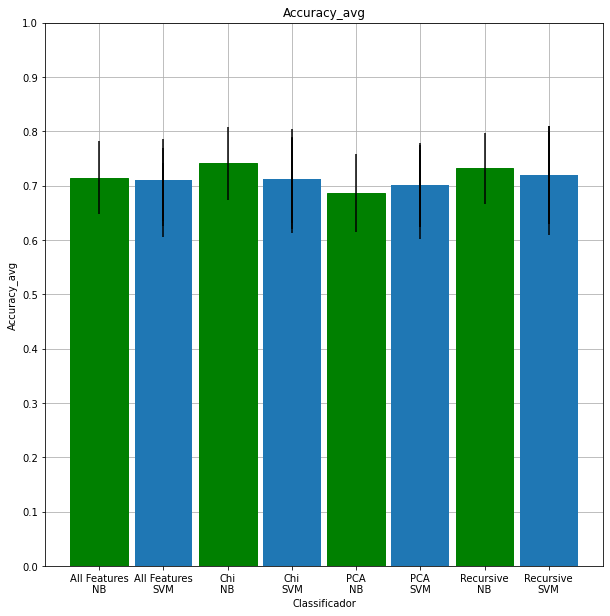

In [64]:

df = G.sort_index()
df['Parametros'] = df[['Features','Classificador']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)

conf = [df['accuracy_ic_sup'].array , df['accuracy_ic_inf'].array]
means = df['accuracy_avg'].array
ic = [conf[0]-means , means-conf[1]]


g = plt.bar(df['Parametros'].array, df['accuracy_avg'].array, yerr=ic,width=0.9,zorder=2,align='center')
plt.grid()
g[0].set_color('g')
g[4].set_color('g')
g[8].set_color('g')
g[12].set_color('g')
plt.title("Accuracy_avg")
plt.ylabel('Accuracy_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


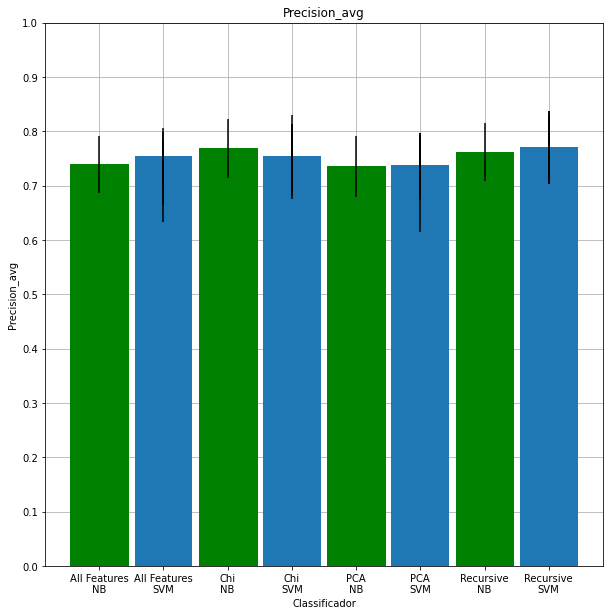

In [63]:
df = G.sort_index()
df['Parametros'] = df[['Features','Classificador']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)
conf = [df['precision_ic_sup'].array , df['precision_ic_inf'].array]
means = df['precision_avg'].array
ic = [conf[0]-means , means-conf[1]]
g = plt.bar(df['Parametros'].array, df['precision_avg'].array, yerr=ic,width=0.9,zorder=2)
plt.grid()
g[0].set_color('g')
g[4].set_color('g')
g[8].set_color('g')
g[12].set_color('g')
plt.title("Precision_avg")
plt.ylabel('Precision_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

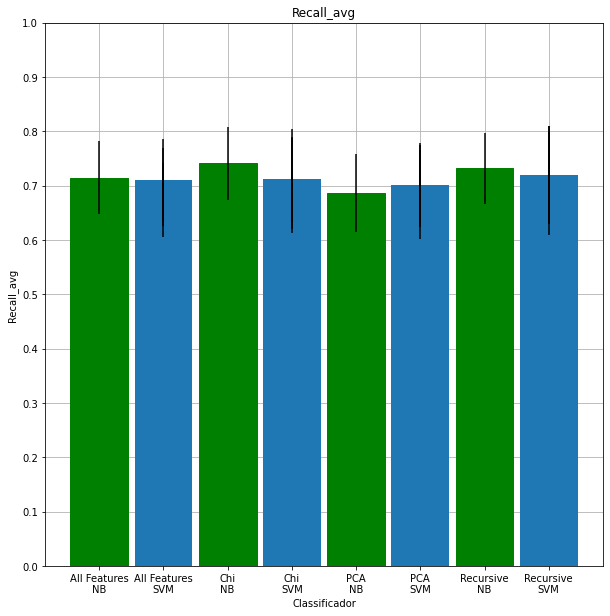

In [62]:
df = G.sort_index()
df['Parametros'] = df[['Features','Classificador']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)
conf = [df['recall_ic_sup'].array , df['recall_ic_inf'].array]
means = df['recall_avg'].array
ic = [conf[0]-means , means-conf[1]]
g = plt.bar(df['Parametros'].array, df['recall_avg'].array, yerr=ic,width=0.9,zorder=2)
plt.grid()
g[0].set_color('g')
g[4].set_color('g')
g[8].set_color('g')
g[12].set_color('g')
plt.title("Recall_avg")
plt.ylabel('Recall_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (10,10)
plt.show()